# Clustering by RNA: Integration

*See the original hypothesis in `notebooks/cluster-rna.ipynb`*

Integrating data from [Poscablo 2024](https://doi.org/10.1016/j.cell.2024.04.018) and an [internal perinatal nicotine exposure dataset (dubbed PNE)](https://cells.ucsc.edu/?ds=mouse-pne-project+bonemarrow) may provide more insight. 

**Hypothesis**: When comparing young and old HSCs, old HSCs form distinct subclusters that may inform whether said old HSC would differentiate down the known hematopoiesis tree or to become a non-canonical MKP.

In [32]:
# setup: imports

# import scanpy as sc
from scanpy import read_h5ad, AnnData
from scanpy.preprocessing import pca as pp_pca, neighbors as pp_neighbors
from scanpy.tools import umap as tl_umap
from scanpy.plotting import umap as pl_umap

import scanpy as sc

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import pandas as pd

from pathlib import Path
from typing import Any
import pyrootutils

# setup: path constants

ROOT = pyrootutils.setup_root(Path.cwd(), indicator='.git')
DATA = ROOT / "data"
FIGURES = ROOT / "figures/cluster-rna-integrated"

POSCABLO_PATH = DATA / "rna_annotation_normalized.h5ad"
PNE_PATH = DATA / "pne-bonemarrow.h5ad"

# setup: verify paths

for path in POSCABLO_PATH, PNE_PATH:
    if not path.exists():
        raise FileNotFoundError(f"Could not find required input: {str(path)}")

FIGURES.mkdir(parents=True, exist_ok=True)

Let's render our two to-be-integrated anndata objects and view their current UMAP embeddings to get a sense of what our data looks like. These datasets share label:color maps, so after guaranteeing that property we can visualize them with a shared legend.

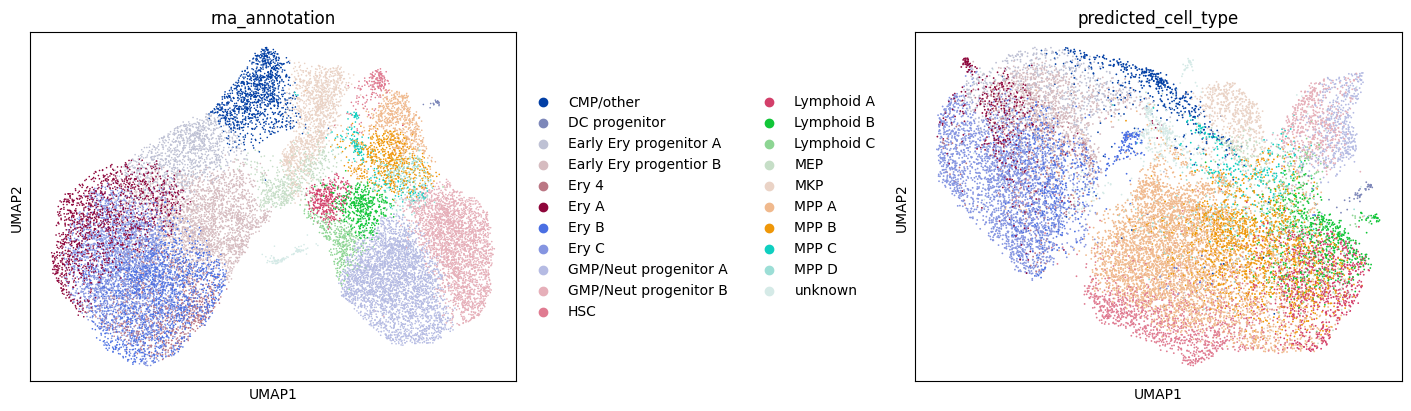

In [34]:
poscablo = read_h5ad(filename=POSCABLO_PATH)
pne = read_h5ad(filename=PNE_PATH)


def plot_shared_celltypes(adata1, color_col1, adata2, color_col2):
    # if poscablo and pne share the same legend, only plot one of em
    legend_loc = None if all(adata1.uns[color_col1 + "_colors"] == adata2.uns[color_col2 + "_colors"]) else 'right margin'

    fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(14, 4))
    axs[0] = sc.pl.umap(adata=adata1, color=color_col1, ax=axs[0], show=False)
    axs[1] = sc.pl.umap(adata=adata2, color=color_col2, ax=axs[1], show=False, legend_loc=legend_loc)


plot_shared_celltypes(
    adata1=poscablo, color_col1='rna_annotation',
    adata2=pne, color_col2='predicted_cell_type'
)

A little sanity check on the individual samples sequenced for the PNE dataset reveals that there is virtually no intra-dataset batch effects that may impact this analysis.

In [ ]:
def plot_batches(adata: AnnData, batch_col: str, suptitle: str = "Treatment") -> None:
    batches = adata.obs[batch_col].unique()
    fig, axs = plt.subplots(
        nrows=1, 
        ncols=len(batches), 
        figsize=(5 * len(batches), 5), 
        constrained_layout=True
    )
    fig.suptitle(suptitle, size='xx-large')
    for ax, batch in zip(axs, batches):
        sc.pl.umap(
            adata=adata[adata.obs[batch_col] == batch], 
            ax=ax, 
            show=False, 
            title=f"Batch: {batch}", 
            legend_loc='best',
        )

# # uncomment function call to see by-treatment UMAP, but they're basically the same
# plot_batches(adata=pne, batch_col='Treatment', suptitle="Batch Effects for PNE Bone Marrow Dataset")

### Preparing for integration

**Joint Genes**
- self explanatory

**Filtering for CONTROL Mice**
- Nicotine exposure would be a confounding variable in this analysis, as we are only concerned with age. Only control mice will be selected for integration with Poscablo.

**Adding features**
- All PNE mice are young, so an Age column did not exist. Adding that and a batch label allows integration methods to differ between datasets.

**UMAP re-calculation**
- Just to get a sense of what the data looks like, the control-only UMAP is re-calculated and re-plotted

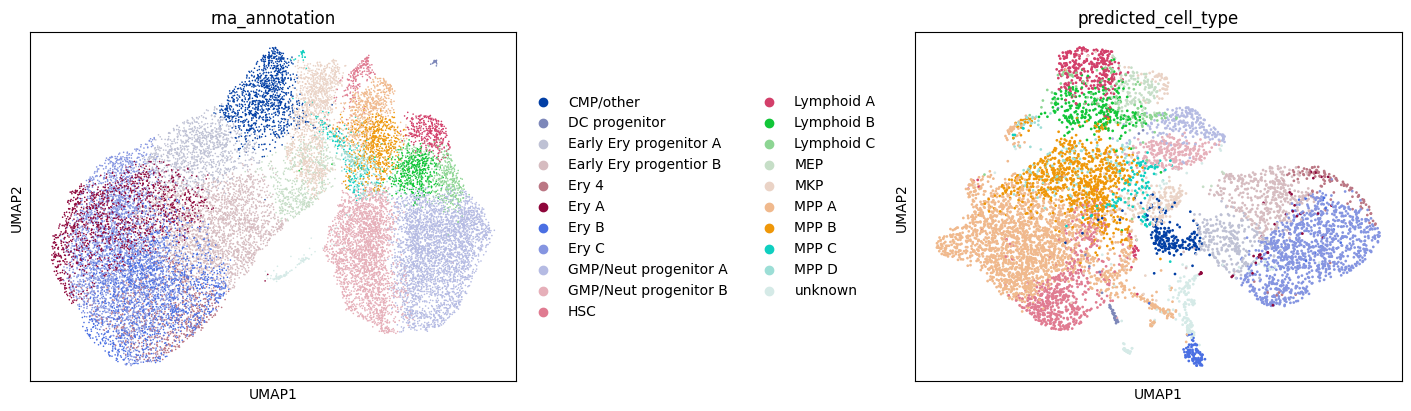

In [ ]:
# select common genes
var_names = poscablo.var_names.intersection(pne.var_names)
poscablo = poscablo[:, var_names].copy()
pne = pne[:, var_names].copy()

# filter pne dataset for control mice
pne_ctrl = pne[pne.obs['Treatment'] == 'CONTROL'].copy()

# add age, batch, and cell type label features to datasets
poscablo_annot, pne_annot = 'rna_annotation', 'predicted_cell_type'
annot = 'cell_type_label'

pne_ctrl.obs['Age'] = pd.Categorical(['Young'] * len(pne_ctrl), categories=poscablo.obs['Age'].cat.categories)
pne_ctrl.obs['batch'] = 'pne'
pne_ctrl.obs[annot] = pne_ctrl.obs[pne_annot]
poscablo.obs['batch'] = 'poscablo'
poscablo.obs[annot] = poscablo.obs[poscablo_annot]


# recompute control-only umaps
for adata in poscablo, pne_ctrl:
    sc.pp.pca(data=adata)
    sc.pp.neighbors(adata=adata)
    sc.tl.umap(adata=adata)

# plot control-only umaps
plot_shared_celltypes(
    adata1=poscablo, color_col1='rna_annotation',
    adata2=pne_ctrl, color_col2='predicted_cell_type'
)

In [39]:
annot = 'cell_type_label'
pne_ctrl.obs[annot] = pne_ctrl.obs['predicted_cell_type']
poscablo.obs[annot] = poscablo.obs['rna_annotation']

### Integration methods

methods
- sc.tl.ingest
    - KNN-based approach
- sc.external.pp.harmony_integrate
    - python implementation of harmony
- scvi.model.SCVI
    - learned joint representation via variational autoencoder

/home/aspandit/lab/age-analysis/.venv/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


AnnData object with n_obs × n_vars = 7802 × 20383
    obs: 'Sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'EGFP', 'TDTOM', 'Egfp_expression', 'S_score', 'G2M_score', 'phase', 'predicted_cell_type', 'Fraction', 'Treatment', 'Age', 'batch', 'cell_type_label'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'Egfp_expression_colors', 'Sample_colors', 'cell_type_colors', 'cell_type_gfp_colors', 'leiden_res_0.02', 'leiden_res_0.02_colors', 'leiden_res_0.50', 'leiden_res_0.50_colors', 'leiden_res_1.00', 'leiden_res_1.00_colors', 'leiden_res_2.00', 'leiden_res_2.00_colors', 'log1p', 'neighbors', 'pca', 'predicted_cell_type_colors', 'predicted_doublet_colors', 'rank_genes_groups', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_umap', 'rep'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

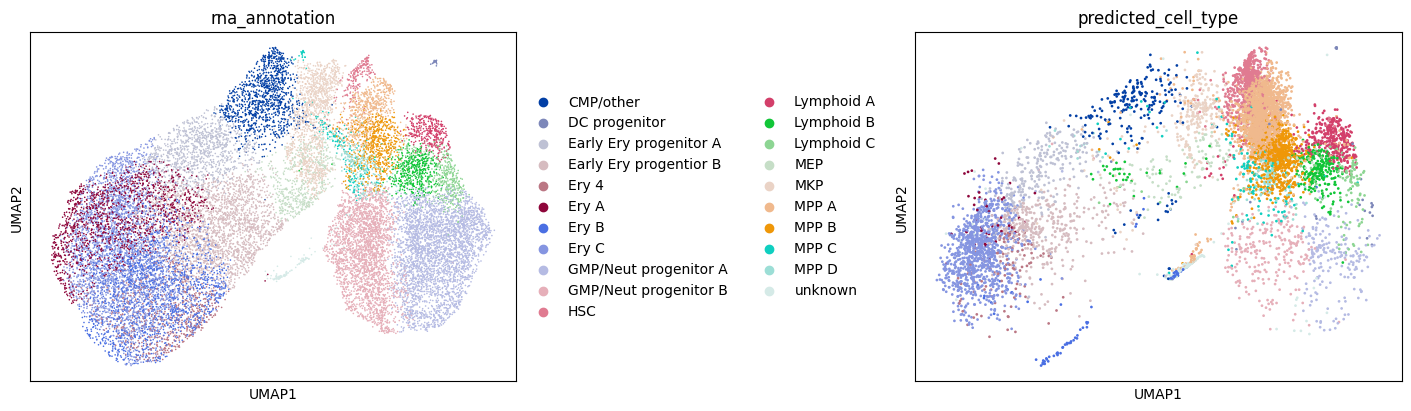

In [45]:
ingested_pne_ctrl = sc.tl.ingest(
    adata=pne_ctrl,
    adata_ref=poscablo,
    inplace=False
)

plot_shared_celltypes(adata1=poscablo, color_col1=poscablo_annot, adata2=ingested_pne_ctrl, color_col2=pne_annot)
ingested_pne_ctrl

In [46]:
joint_adata = sc.concat(adatas=[poscablo, pne_ctrl])
joint_adata

AnnData object with n_obs × n_vars = 30404 × 20383
    obs: 'Age', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'Egfp_expression', 'batch', 'cell_type_label'
    obsm: 'X_pca', 'X_umap'